In [49]:
# Core
import os
import cv2
import numpy as np
import pandas as pd
import collections
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau, EarlyStopping


# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [50]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('pranavraikokte/covid19-image-dataset',unzip=True)

In [52]:
# Load Training Data (80%)
train_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Validation Data (20%)
val_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Test Data (separate folder)
test_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [53]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [54]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)


(32, 128, 128, 3)
(32,)


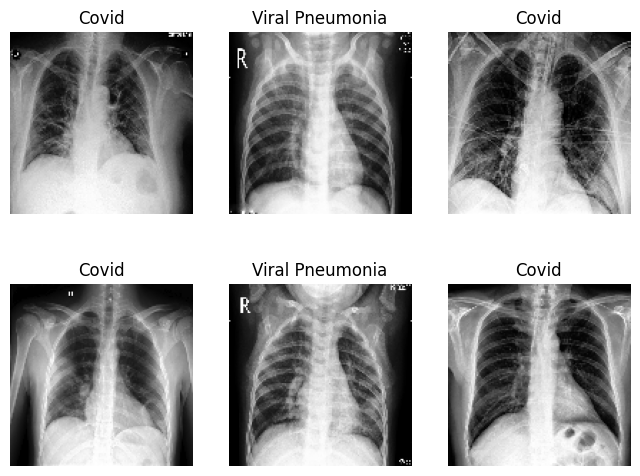

In [ ]:
# Sample data
plt.figure(figsize=(8,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

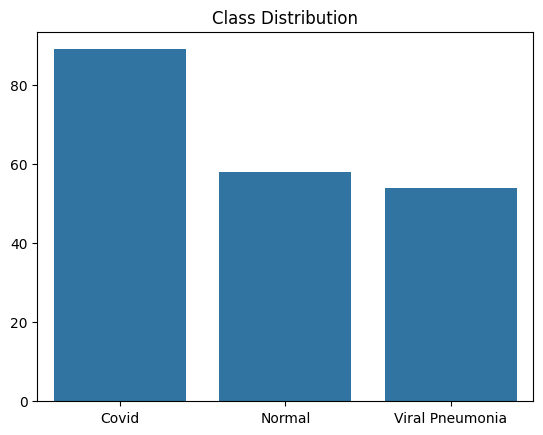

In [ ]:
# Class Distribution
label_count = collections.Counter()

for _, labels in train_ds:
    label_count.update(labels.numpy())

sns.barplot(x=list(label_count.keys()),
            y=list(label_count.values()))
plt.xticks(range(len(class_names)), class_names)
plt.title("Class Distribution")
plt.show()

In [60]:
print("Training samples per class:")
for label, count in label_count.items():
    print(f"{class_names[label]}: {count}")

Training samples per class:
Covid: 89
Normal: 58
Viral Pneumonia: 54


---

### 🔍 EDA Observations

* The dataset shows class imbalance across categories.
* COVID-19 and Pneumonia chest X-ray images share visual similarities, making classification challenging.
* Normal chest X-ray images generally exhibit clearer lung structures with fewer dense regions.

---

In [ ]:
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Tuned CNN

In [ ]:
model = keras.Sequential([
    # Input Layer (Explicit definition helps with debugging)
    layers.Input(shape=(128, 128, 3)),
    
    # Data Augmentation (Active only during training)
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
start_time = time.time()

# 1. Stop if model gets worse 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 2. Reduce Learning Rate if model stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      
    patience=10,      
    min_lr=0.00001   
)

# Train with both callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500, 
    callbacks=[early_stopping, reduce_lr] 
)

end_time = time.time()
total_time = end_time - start_time

print(f"Training time: {total_time:.2f} seconds")
print(f"Training time: {total_time/60:.2f} minutes")

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d')
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.show()


In [ ]:
print(classification_report(
    y_true, y_pred,
    target_names=class_names
))